In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from typing import Dict, Tuple
from IPython.display import display
from matplotlib import pyplot as plt

# Package dependencies:
# https://github.com/anabugaenko/liquidity
# https://github.com/anabugaenko/market_impact

from liquidity.features import compute_aggregate_features

from market_impact.response_functions import aggregate_impact
from market_impact.fit import fit_scaling_form, fit_scaling_law 
from market_impact.fss import find_shape_parameters, find_scale_factors, transform
from market_impact.util.data_utils import normalize_imbalances, bin_data_into_quantiles, smooth_outliers, plot_scaling_form, plot_scaling_law

In [2]:

# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

# Nonlinear aggregate price impact analysis 

See:

Lillo, F., Farmer, J.D. and Mantegna, R.N., 2003. Master curve for </br>
price-impact function. Nature, 421(6919), pp.129-130.

Patzelt, F. and Bouchaud, J.P., 2018. Universal scaling and nonlinearity of </br>
aggregate price impact in financial markets. Physical Review E, 97(1), p.012304.</br>

## Finitie-size scaling analysis
Finite-size scaling analysis a powerful tool that enables extraction of exponent of critical phenomena. Given data describing some dimensionless quantity, we estimate universal information from observables at finite-size system. The derivation of such scaling laws is supported by the renormalization-group argument. This notebook introduces a FSS based on the method of Leas-squares.

In [3]:
# Constants 
BINNING_FREQUENCIES = list(range(10, 151))
OBSERVATION_WINDOWS = [10, 20, 50, 100, 150]

In [4]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL', 'GOOG']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_data = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_data[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_data['TSLA']
amzn_raw_df = stock_data['AMZN']
nflx_raw_df = stock_data['NFLX']
msft_raw_df = stock_data['MSFT']
ebay_raw_df = stock_data['EBAY']
aapl_raw_df = stock_data['AAPL']
goog_raw_df = stock_data['GOOG']

In [5]:
tsla_raw_df.head()

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,average_vol_at_best,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:19.351489154,1,ASK,UPDATE,True,219.37,1,219.37,219.28,...,124.329354,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.008043,1
1,1,2017-01-03 10:30:19.351537884,1,ASK,REMOVE,True,219.37,15,219.37,219.28,...,124.329354,0.005,0.005,0.09,2017-01-03,0.021159,277786,3279,0.120647,15
2,2,2017-01-03 10:30:19.351549791,1,ASK,UPDATE,True,219.38,80,219.38,219.28,...,124.329354,0.005,0.005,0.10,2017-01-03,0.021159,277786,3279,0.643452,80
3,3,2017-01-03 10:30:19.351601187,1,ASK,UPDATE,True,219.38,80,219.38,219.29,...,124.329354,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.643452,80
4,4,2017-01-03 10:30:19.351702603,1,ASK,REMOVE,True,219.38,40,219.38,219.29,...,124.329354,0.050,0.050,0.09,2017-01-03,0.021159,277786,3279,0.321726,40


### Aggregate features 
We first coarse-grain the data into different binning frequencies $T$ that represent different system sizes (in event time) by marginalize over microscopic degrees of freedom in the system to yield an effective coarse-grained description at long distances.

In [6]:
# Compute aggregate features 
aggregate_features = compute_aggregate_features(aapl_raw_df, BINNING_FREQUENCIES)
aggregate_features

,event_timestamp,midprice,sign,signed_volume,price_changing,daily_R1,daily_num,daily_vol,volume_imbalance,sign_imbalance,price_change_imbalance,average_num_at_best,average_vol_at_best,T
0,2017-01-03 10:30:00.544161131,115.695,1,100,True,0.004271,6170,1398089,817,8,5,7.283424,1045.040418,10
1,2017-01-03 10:30:10.310456548,115.705,1,10,False,0.004271,6170,1398089,640,4,6,7.283424,1045.040418,10
2,2017-01-03 10:30:19.747284743,115.735,-1,-372,True,0.004271,6170,1398089,124,0,8,6.032068,762.184840,10
3,2017-01-03 10:30:28.752706970,115.735,-1,-100,False,0.004271,6170,1398089,545,2,3,6.032068,762.184840,10
4,2017-01-03 10:30:33.462045557,115.745,1,64,True,0.004271,6170,1398089,2319,2,6,7.283424,1045.040418,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17555,2017-12-29 14:10:23.616797445,169.965,-1,-100,True,0.030568,6735,1452499,-66,6,73,3.890007,725.867637,150
17556,2017-12-29 14:19:43.787737053,169.985,1,150,True,0.030568,6735,1452499,-8366,-18,82,3.711482,773.098946,150
17557,2017-12-29 14:33:25.027775392,169.985,-1,-2219,True,0.030568,6735,1452499,-10091,-2,69,3.890007,725.867637,150
17558,2017-12-29 14:43:12.455575283,169.985,1,300,False,0.030568,6735,1452499,-10114,-26,75,3.711482,773.098946,150


### Aggregate imapct
From aggegate features, we compute aggregate impact of market orders MO. All impact data is automatically normalized in preprartion for fss analysis.

In [7]:
# Compute data for susceptibility
aggregate_impact_data = aggregate_impact(aggregate_features, normalize=True)
display(aggregate_impact_data)

,T,volume_imbalance,R
0,10,0.000584,2.341556
1,10,0.000458,7.024668
2,10,0.000089,0.000000
3,10,0.000390,2.341556
4,10,0.001659,-2.341556
...,...,...,...
17555,150,-0.000045,0.654281
17556,150,-0.005760,0.000000
17557,150,-0.006947,0.000000
17558,150,-0.006963,-0.981421


### Determine shape parameters  
Determine the shape parameters $\alpha$ and $\beta$ of scaling function $\mathscr{F}(\cdot)$ by fitting the</b>
scaling function for $\textit{all}$ $T$.

In [8]:
alpha, beta = find_shape_parameters(aggregate_impact_data, imbalance_column="volume_imbalance")
print(f'alpha: {alpha}')
print(f'beta: {beta}')

alpha: 0.6486997501157479
beta: 2.0622792864543995


### Map-out scale factors
Once $\mathscr{F}(\cdot)$ is fixed, one can map out the scale factors as a function of $T$ (i.e., for each $T$), which are well very approximated by power-laws of $T$.

[]

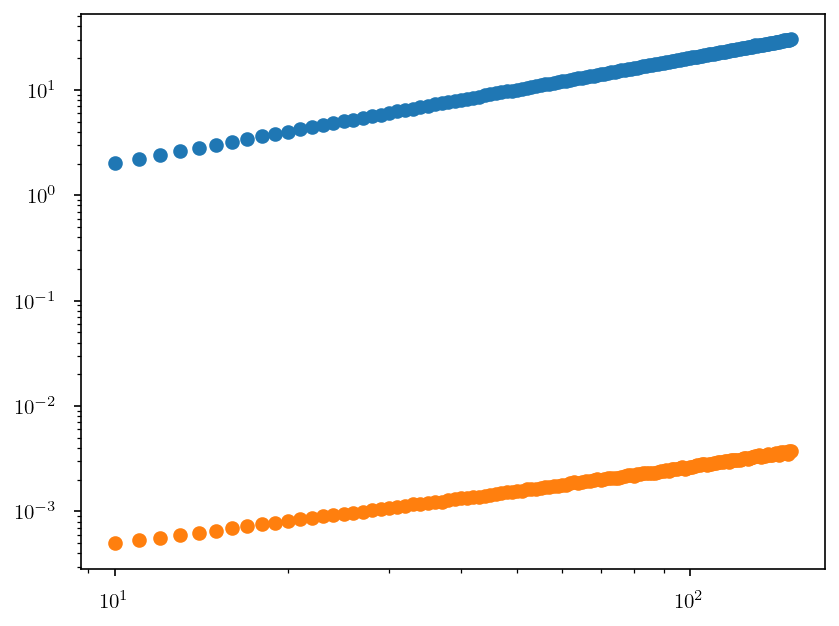

In [10]:
RT_series, VT_series, RT_fit_object, VT_fit_object = find_scale_factors(aggregate_impact_data, alpha=alpha, beta=beta, imbalance_column="volume_imbalance")
# Plot scale factors RN and QN
plt.scatter(RT_series['x_values'], RT_series['y_values'])
plt.scatter(VT_series['x_values'], VT_series['y_values'])
plt.loglog()

### Determine rescaling exponents
In order to determine the rescaling exponents $\chi$ and $\varkappa$, the shape of the scaling form is fitted for each $T$ keeping the same/constant values of $\alpha$ $\beta$,</b> which are well approximated by the power law.

In [11]:
chi = RT_fit_object.powerlaw.params.alpha
kappa = VT_fit_object.powerlaw.params.alpha
print(chi)
print(kappa)

0.9992301388700421
0.78057755138878


## Plot scaling form 
We plot the scaling for $\textit{differet/each}$ binning frequencies $T$, where the aggregate impact of $T$ trades $\textit{"appears"}$ to grow linear in volume imbalance with increasing $T$.

In [9]:
# Plot final rescaled functions
imbalance_column = "volume_imbalance"

scaling_form_params = {}
for T in OBSERVATION_WINDOWS:
    data = aggregate_impact_data[aggregate_impact_data['T']==T][["T", imbalance_column, "R"]]
    data.replace([np.inf, -np.inf], np.nan, inplace=False)
    data.dropna(inplace=True)

    T_values = data['T'].values
    imbalance_values = data[imbalance_column].values
    R_values = data['R'].values

    param = fit_scaling_form(T_values, imbalance_values, R_values, reflect_y=False)
    scaling_form_params[T] = param

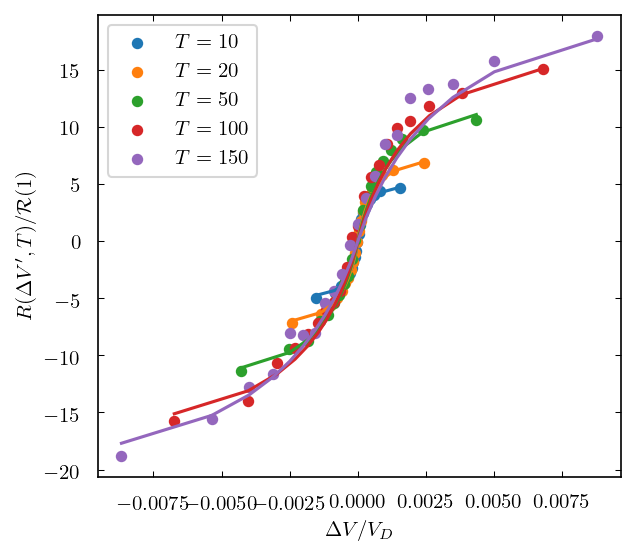

In [10]:
plot_scaling_form(aggregate_impact_data, original_parameters=scaling_form_params, q=21, observation_windows=OBSERVATION_WINDOWS, imbalance_column=imbalance_column)

### Plot scaling law after renomalization
We can now substitute the found emeprical scaling laws for $R_T$ and $V_T$ and use the found scaling law critical paramters $\chi$ and $\varkappa$ to rescale the scaling function onto a single master curve. 

In [23]:
# Initial fit of scaling law to all T
T_values = aggregate_impact_data['T'].values
imbalance_values = aggregate_impact_data[imbalance_column].values
R_values = aggregate_impact_data['R'].values

original_params = fit_scaling_law(T_values, imbalance_values, R_values, reflect_y=False)

In [24]:
# Retrieve optimized parameters
chi, kappa, alpha, beta, CONST = original_params
print(f'chi: {chi}')
print(f'kappa: {kappa}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')
print(f'CONST: {CONST}')

chi: 0.5126153602966497
kappa: 0.8187673486541124
alpha: 0.4480614405457005
beta: 39.745152678601016
CONST: 52534.21906141031


In [25]:
# Transform original shape parameters 𝛼 and 𝛽 using found rescaling exponents chi 𝛘 and kapp ϰ
rescaled_params = transform(aggregate_impact_data, renomalization_params=original_params, imbalance_column=imbalance_column)

### Master curve
Plot final collapsed data rescaled by critical exponents chi 𝛘 and kapp ϰ so that that data collapses onto a single master curve

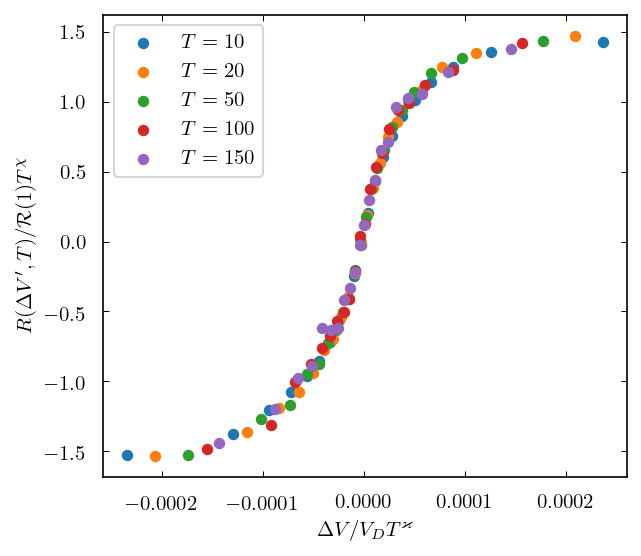

In [26]:
# Plot master curve
plot_scaling_law(rescaled_data=rescaled_params, q=21, observation_windows=OBSERVATION_WINDOWS, imbalance_column=imbalance_column)